This is based on the original PMCX tutorial: 
https://colab.research.google.com/github/fangq/mcx/blob/master/pmcx/tutorials/pmcx_getting_started.ipynb#scrollTo=LnrnJOcJsQzW

In [1]:
import numpy as np
import pmcx
import jdata as jd
from matplotlib import pyplot as plt

print(pmcx.__version__)
print(pmcx.gpuinfo())

0.2.7
[{'name': 'GeForce RTX 2070 SUPER', 'id': 1, 'devcount': 1, 'major': 7, 'minor': 5, 'globalmem': 8589934592, 'constmem': 65536, 'sharedmem': 49152, 'regcount': 65536, 'clock': 1770000, 'sm': 40, 'core': 2560, 'autoblock': 64, 'autothread': 81920, 'maxgate': 0}]


nphoton: 1e+06
tstart: 0
tstep: 5e-09
tend: 5e-09
srcpos: [30, 30, 0, 1]
srcdir: [0, 0, 1, 0]


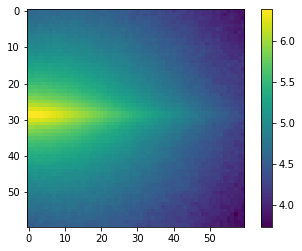

In [2]:
# define simulation (as a dictionary variable)
cfg = {
       'nphoton': 1000000,                          # no. of photons to be used in the Monte Carlo sim
       'vol':np.ones([60,60,60],dtype='uint8'),     # define a volume. Specify media index for each voxel. 
                                                    # default units in mm
       'tstart':0,                                  # start time of simulation
       'tend':5e-9,                                 # end time of simulation
       'tstep':5e-9,
       'srcpos': [30,30,0],                         # position(s) of light source(s) in XYZ coordinates
       'srcdir':[0,0,1],                            # lighting direction of light source(s)
       'prop':[[0,0,1,1],[0.005,0.1,0.01,1.37]]     # properties of optical medium (mu_a, mu_s, g, n)
       }

# run PMCX simulation
res = pmcx.mcxlab(cfg)      # or res=pmcx.run(cfg)

# visualize results
plt.imshow(np.log10(res['flux'][30,:,:]))
plt.colorbar()
plt.show()

When using a `dict` cfg input, it is recommended to call `pmcx.mcxlab(cfg)` instead of `pmcx.run()` because `pmcx.mcxlab()` contains the pre- and post-processing code to make the output `res` similar to those returned by `mcxlab()` in MATLAB/Octave.

Specificically, `pmcx.mcxlab()` further processes the `res['detp']` data into directionary with keys `{'detid', 'ppath', 'nscat', 'p', 'v', 'mom', 'iquv', 'w0'}` depends on `cfg['savedetflag']` and related input settings. In addition, `pmcx.mcxlab()` also process `res['traj']` trajectory data into directionary-formatted output for easy processing, including keys like `{'id', 'pos'}`. Please run `help(pmcx.mcxlab)` for more details.

nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
srcpos: [30, 30, 0, 1]
srcdir: [0, 0, 1, 0]
dict_keys(['flux', 'stat'])
{'runtime': 367, 'nphoton': 10000000, 'energytot': 10000000.0, 'energyabs': 2733963.9301223755, 'normalizer': 20.0, 'unitinmm': 1.0, 'workload': [2560.0]}


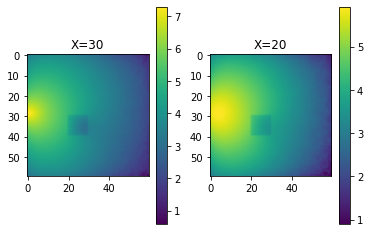

In [3]:
# another example
# here we define 2 media indexes (indexed as 1 and 2)
cfg={}
cfg['nphoton']=1e7
cfg['vol']=np.ones([60, 60, 60], dtype='uint8')
cfg['vol'][20:40, 30:40, 20:30]=2
cfg['tstart']=0
cfg['tend']=5e-9
cfg['tstep']=5e-9
cfg['srcpos']=[30,30,0]
cfg['srcdir']=[0,0,1]
# medium properties to be defined for all medium indices
cfg['prop']=[[0, 0, 1, 1], [0.005, 1, 0.01, 1.37], [0.1, 10, 0.9, 1]]

# run PMCX simulation
res = pmcx.mcxlab(cfg)      # or res=pmcx.run(cfg)
print(res.keys())
print(res['stat'])

# visualize results
plt.subplot(121); plt.imshow(np.log10(res['flux'][30,:,:])); plt.title('X=30'); plt.colorbar()
plt.subplot(122); plt.imshow(np.log10(res['flux'][20,:,:])); plt.title('X=20'); plt.colorbar()
plt.show()


### Set up detectors and detection flags

In [5]:
cfg={}
cfg['nphoton']=1e7
cfg['vol']=np.ones([60, 60, 60], dtype='uint8')
cfg['vol'][20:40, 30:40, 20:30]=2
cfg['tstart']=0
cfg['tend']=5e-9
cfg['tstep']=5e-9
cfg['srcpos']=[30,30,0]
cfg['srcdir']=[0,0,1]
cfg['prop']=[[0, 0, 1, 1], [0.005, 1, 0.01, 1.37], [0.1, 10, 0.9, 1]]
cfg['detpos']=[[30,27,0,1], [30,25,0,1]]   # to detect photons, one must first define detectors
cfg['issavedet']=1                         # cfg.issavedet must be set to 1 or True in order to save detected photons
cfg['issrcfrom0']=1                        # set this flag to ensure src/det coordinates align with voxel space

# run MCX simulation
res = pmcx.mcxlab(cfg)
print(res.keys())

nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
issrcfrom0: 1
srcpos: [30, 30, 0, 1]
srcdir: [0, 0, 1, 0]
issavedet: 1
dict_keys(['detp', 'flux', 'stat'])


### Output:
      fluence: a struct array, with a length equals to that of cfg.
            For each element of fluence, 
            fluence(i).data is a 4D array with
                 dimensions specified by [size(vol) total-time-gates]. 
                 The content of the array is the normalized fluence at 
                 each voxel of each time-gate.

                 when cfg.debuglevel contains 'T', fluence(i).data stores trajectory
                 output, see below
            fluence(i).dref is a 4D array with the same dimension as fluence(i).data
                 if cfg.issaveref is set to 1, containing only non-zero values in the 
                 layer of voxels immediately next to the non-zero voxels in cfg.vol,
                 storing the normalized total diffuse reflectance (summation of the weights 
                 of all escaped photon to the background regardless of their direction);
                 it is an empty array [] when if cfg.issaveref is 0.
            fluence(i).stat is a structure storing additional information, including
                 runtime: total simulation run-time in millisecond
                 nphoton: total simulated photon number
                 energytot: total initial weight/energy of all launched photons
                 energyabs: total absorbed weight/energy of all photons
                 normalizer: normalization factor
                 unitinmm: same as cfg.unitinmm, voxel edge-length in mm

      detphoton: (optional) a struct array, with a length equals to that of cfg.
            Starting from v2018, the detphoton contains the below subfields:
              detphoton.detid: the ID(>0) of the detector that captures the photon
              detphoton.nscat: cummulative scattering event counts in each medium
              detphoton.ppath: cummulative path lengths in each medium (partial pathlength)
                   one need to multiply cfg.unitinmm with ppath to convert it to mm.
              detphoton.mom: cummulative cos_theta for momentum transfer in each medium  
              detphoton.p or .v: exit position and direction, when cfg.issaveexit=1
              detphoton.w0: photon initial weight at launch time
              detphoton.s: exit Stokes parameters for polarized photon
              detphoton.prop: optical properties, a copy of cfg.prop
              detphoton.data: a concatenated and transposed array in the order of
                    [detid nscat ppath mom p v w0]'
              "data" is the is the only subfield in all MCXLAB before 2018
      vol: (optional) a struct array, each element is a preprocessed volume
            corresponding to each instance of cfg. Each volume is a 3D int32 array.
      seeds: (optional), if give, mcxlab returns the seeds, in the form of
            a byte array (uint8) for each detected photon. The column number
            of seed equals that of detphoton.
      trajectory: (optional), if given, mcxlab returns the trajectory data for
            each simulated photon. The output has 6 rows, the meanings are 
               id:  1:    index of the photon packet
               pos: 2-4:  x/y/z/ of each trajectory position
                    5:    current photon packet weight
                    6:    reserved
            By default, mcxlab only records the first 1e7 positions along all
            simulated photons; change cfg.maxjumpdebug to define a different limit.